<a href="https://colab.research.google.com/github/pragamarcos/Informe_predictivo_mercado_editorial/blob/main/Informe_predictivo_mercado_editorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis Predictivo de Precios en el Mercado Editorial Argentino


## Caso de Estudio: Catálogo Yenny-El Ateneo

---

**Motivación:**  
El mercado editorial argentino presenta una gran variabilidad en los precios de los libros, influenciada por múltiples factores como el género literario, la extensión, el tipo de encuadernación y la editorial. Comprender qué variables determinan el precio de un libro resulta fundamental para optimizar estrategias comerciales, mejorar la competitividad y facilitar la toma de decisiones tanto para editoriales como para distribuidores y vendedores independientes.

**Objetivo:**  
Este proyecto busca analizar el comportamiento de los precios en el catálogo de una de las librerías más importantes de Argentina, identificando patrones y relaciones entre las características de los libros y sus precios de venta al público y finalmente poder armar y mantener un modelo de machine learning que sea capaz de predecir el precio de un libro cuando se tiene por lo menos algunas de las variables claves para ello.

**Audiencia:**  
Este análisis está dirigido a:
- Gerentes comerciales y de producto de editoriales
- Responsables de pricing en librerías y cadenas de retail para gestión de inventario y pricing dinámico.

El foco esta en la carga de datos principales de los libros para que el modelo arroje finalmente un precio medio en base al historico vendido y las condiciones de publicacion (editorial, edicion, nro. de paginas, etc.)

---

Se busca además responder las siguientes preguntas clave:

**1. Análisis Univariado:**
- ¿Cuál es la distribución de precios en el catálogo?
- ¿Qué categorías y géneros literarios dominan el mercado?
- ¿Cómo se distribuye el número de páginas de los libros?
- ¿Cuál es la distribución de tipos de encuadernación?

**2. Análisis Bivariado:**
- ¿Existe correlación entre el número de páginas y el precio?
- ¿Qué categorías literarias tienen los precios más altos en promedio?

**3. Análisis Multivariado:**
- ¿Existen interacciones entre variables que impacten el precio?
- ¿Cuál es el indice de relacion entre las variables?
- ¿Se pueden identificar segmentos de mercado con características similares?

## Configuración del Entorno de Trabajo

Importamos las librerías necesarias para el análisis de datos y visualización.

In [ ]:
#Importo las librerias que necesito para EDA y analisis grafico
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from tqdm import tqdm
from scipy import stats
from google.colab import files
import warnings
import time

warnings.filterwarnings('ignore')

#Seteo también el entorno de matplotlib y seaborn por defecto
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

#Instalo las librerias necesarias para ML
from sklearn.experimental import enable_halving_search_cv
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, HalvingGridSearchCV, cross_validate
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import Pipeline
import joblib

# Adquisición de Datos

Los datos fueron obtenidos del catálogo público de **Yenny-El Ateneo**, una de las cadenas de librerías más importantes de Argentina, mediante kaggle usando la informacion que comparten y hacen publica. El dataset se encuentra almacenado en un repositorio de GitHub en formato CSV.

**Fuente de datos:** Catálogo público Yenny-El Ateneo  
**Método de obtención:** Descarga del dataset de Kaggle.com  
**Formato:** CSV  
**Período de recolección:** 2024-2025

In [ ]:
url = "https://raw.githubusercontent.com/pragamarcos/publicaciones_libros_ateneo/refs/heads/main/publicaciones_libros_ateneo.csv"
df = pd.read_csv(url)


# EDA - Exploración Inicial del Dataset

### Vista Preliminar de los Datos

Realizamos una primera inspección para revisar la estructura del dataset y las variables disponibles.

In [ ]:
df.sample(10)

,url,codigo_isbn,titulo,autor,editorial,idioma,nro_paginas,fecha_publicacion,encuadernacion,categoria,genero,subgenero,precio
9263,https://www.yenny-elateneo.com/productos/el-se...,9789878380292,EL SECRETO DE LOS TIEMPOS,Robert Collier,Del Fondo Editorial,Español,278.0,10/2024,Tapa Blanda,AUTOAYUDA,SUPERACION PERSONAL,EN GENERAL,22900
14870,https://www.yenny-elateneo.com/productos/la-sa...,9788411211352,LA SABIDURIA DEL NO SABER,Antonio Lozano Domenech,Kairos,Español,160.0,08/2024,Tapa Blanda,AUTOAYUDA,SUPERACION PERSONAL,EN GENERAL,31180
12247,https://www.yenny-elateneo.com/productos/la-li...,9789500728799,LA LIBERTADORA (1955-1958),Maria Saenz Quesada,Sudamericana,Español,512.0,10/2007,Tapa Blanda,DERECHO Y CIENCIAS SOCIALES,HISTORIA,HISTORIA ARGENTINA,42999
1529,https://www.yenny-elateneo.com/productos/el-me...,9788419685520,EL METODO SEDONA,Hale Dwoskin,Editorial Sirio,Español,392.0,02/2025,Tapa Blanda,"CIENCIAS DE LA SALUD, NATURALES Y DIVULGACION ...",MEDICINA,ESPECIALIDADES,33900
8324,https://www.yenny-elateneo.com/productos/unico...,9789877979459,UNICORNIOS - DIVERSION SORPRESA,Guadal El Gato De Hojalata,Guadal,Español,32.0,07/2023,Tapa Blanda,INFANTIL Y JUVENIL,DIDÁCTICOS,EN GENERAL,25299
66,https://www.yenny-elateneo.com/productos/la-te...,9788417412999,LA TECNICA DEL MOULAGE VOL. 2,Danilo Attardi,Promopress,Español,192.0,07/2022,Tapa Blanda,"ARTE, ARQUITECTURA Y DISEÑO",TÉCNICAS ARTÍSTICAS,DIBUJO,64200
14465,https://www.yenny-elateneo.com/productos/super...,9789878193427,SUPERMAN: POR EL MAÑANA,Brian Azzarello,Ovni Press,Español,320.0,02/2025,Tapa Blanda,FICCIÓN Y LITERATURA,COMIC'S - NOVELA GRAFICA,NOVELAS GRAFICAS Y MANGA,26000
6810,https://www.yenny-elateneo.com/productos/la-an...,9789878267685,LA ANTIPOLITICA Y LOS DESAFIOS DE LA DEMOCRACI...,Leonardo Avritzer,Prometeo,Español,136.0,01/2024,Tapa Blanda,DERECHO Y CIENCIAS SOCIALES,POLITICA,NACIONAL,13900
1760,https://www.yenny-elateneo.com/productos/el-li...,9789877181166,EL LIBRO DE LOS DATOS INUTILES,Johnny Joker,Ediciones Lea,Español,64.0,06/2014,Tapa Blanda,INFANTIL Y JUVENIL,ENTRETENIMIENTOS,GENERALES,9900
180,https://www.yenny-elateneo.com/productos/se-no...,9786316632326,SE NOS ACABA EL TIEMPO,Segundo Cernadas,Galerna,Español,256.0,03/2025,Tapa Blanda,FICCIÓN Y LITERATURA,NOVELAS,ARGENTINA,22000


### Dimensiones del Dataset

Verificamos el tamaño del dataset para entender la cantidad de información disponible para el análisis.

In [ ]:
df.shape

(15642, 13)

### Estructura y Tipos de Datos

Analizamos los tipos de datos de cada variable y verificamos la presencia de valores nulos.

In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15642 entries, 0 to 15641
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   url                15642 non-null  object 
 1   codigo_isbn        15642 non-null  int64  
 2   titulo             15642 non-null  object 
 3   autor              15642 non-null  object 
 4   editorial          15642 non-null  object 
 5   idioma             15642 non-null  object 
 6   nro_paginas        14152 non-null  float64
 7   fecha_publicacion  15642 non-null  object 
 8   encuadernacion     15642 non-null  object 
 9   categoria          15642 non-null  object 
 10  genero             15642 non-null  object 
 11  subgenero          15642 non-null  object 
 12  precio             15642 non-null  int64  
dtypes: float64(1), int64(2), object(10)
memory usage: 1.6+ MB


In [ ]:
paginas_en_0 = (df['nro_paginas'] == 0).sum()
print (paginas_en_0)

0


In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df.describe()

,codigo_isbn,nro_paginas,precio
count,1.564200e+04,14152.000000,15642.000000
mean,9.784091e+12,234.178067,25457.519435
std,1.730505e+11,178.058005,14841.054919
min,7.371864e+11,1.000000,1050.000000
25%,9.788419e+12,120.000000,16000.000000
50%,9.789502e+12,200.000000,23500.000000
75%,9.789876e+12,320.000000,31694.750000
max,9.798988e+12,3872.000000,367080.000000


In [ ]:
df.isnull().sum()

,0
url,0
codigo_isbn,0
titulo,0
autor,0
editorial,0
idioma,0
nro_paginas,1490
fecha_publicacion,0
encuadernacion,0
categoria,0


**Observaciones iniciales:**
- El dataset contiene **13 variables** con información bibliográfica y comercial
- Variables numéricas: `nro_paginas`, `precio`, `codigo_isbn`
- Variables categóricas: `titulo`, `autor`, `editorial`, `idioma`, `encuadernacion`, `categoria`, `genero`, `subgenero`
- Se detectan **1,490 valores nulos** en la columna `nro_paginas` (9.5% del total)

## Limpieza y transformación de datos

Revisamos entonces dentro de la estructura que hay variables cuyo tipo de dato no se corresponde con lo que muestra, por lo que se realiza la modificacion correspondiente para que el tipo de dato de la variable se corrija al que corresponde.

In [ ]:
df['fecha_publicacion'].sample(10)

,fecha_publicacion
3883,05/2019
6156,05/2004
6807,11/2019
1228,09/2018
6312,09/2022
13169,01/2025
2513,09/2023
3763,04/2017
2692,09/2016
13592,09/2019


In [ ]:
df['fecha_publicacion'] = pd.to_datetime(df['fecha_publicacion'])

In [ ]:
df.dtypes

,0
url,object
codigo_isbn,int64
titulo,object
autor,object
editorial,object
idioma,object
nro_paginas,float64
fecha_publicacion,datetime64[ns]
encuadernacion,object
categoria,object


In [ ]:
df["año_publicacion"] = df["fecha_publicacion"].dt.year
df["mes_publicacion"] = df["fecha_publicacion"].dt.month

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15642 entries, 0 to 15641
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   url                15642 non-null  object        
 1   codigo_isbn        15642 non-null  int64         
 2   titulo             15642 non-null  object        
 3   autor              15642 non-null  object        
 4   editorial          15642 non-null  object        
 5   idioma             15642 non-null  object        
 6   nro_paginas        14152 non-null  float64       
 7   fecha_publicacion  15642 non-null  datetime64[ns]
 8   encuadernacion     15642 non-null  object        
 9   categoria          15642 non-null  object        
 10  genero             15642 non-null  object        
 11  subgenero          15642 non-null  object        
 12  precio             15642 non-null  int64         
 13  año_publicacion    15642 non-null  int32         
 14  mes_pu

In [ ]:
df['mes_publicacion'].sample(10)

,mes_publicacion
7311,4
12928,10
12992,4
10447,8
4798,4
4179,4
14020,1
14796,4
6194,6
5950,11


Finalmente eliminamos la variable que no vamos a usar mas y tambien borramos la variable URL que no encontramos util para el analisis

In [ ]:
df = df.drop(columns=["fecha_publicacion","url"])

### Detección y corrección de Outliers:

Se investigó al respecto de los outliers y se va a usar la regla de John Tukey (creador del boxplot), convención estadística que incluye el calculo del rango intercuartilico par detectar los outliers y datos fuera de lo comun que pueden estar afectando el correcto funcionamiento de los datos pero vamos a combinarlo con una busqueda web para asegurar la veracidad:

Tukey eligió como regla el calculo de 1.5 * IQR porque, en una distribución normal (campana de Gauss):

- Detecta aproximadamente el 0.7% de valores extremos como outliers

- Es lo suficientemente conservador para no eliminar datos válidos

- Pero lo suficientemente estricto para detectar valores anómalos

A partir de esto vamos a calcular el rango, determinar los outliers y debido a que en la investigacion particular de los casos de precios mas altos y la busqueda en internet dieron como resultado precios distintos (por lo que entendemos que son erroneos), procederemos a eliminar los registros de outliers para evitar que afecten el resultado final del modelo predictivo


Hacemos esto siendo un poco mas permisivos que Tukey, eligiendo 1 * IQR para el cuartil 25 pero 2.5 *IQR para el cuartil 75 y asi incluir libros que de otra manera quedarian injustamente afuera del modelo:


In [ ]:
#Guardamos el tamaño original de la variable target para luego comparar
tamaño_original = len(df)
print(f"Tamaño original de la variable: {tamaño_original}")

# Calculamos cuartiles
Q1 = df['precio'].quantile(0.25)
Q3 = df['precio'].quantile(0.75)
IQR = Q3 - Q1

# Definimos límites
limite_inferior = Q1 - 1 * IQR
limite_superior = Q3 + 2.5 * IQR

print("LÍMITES PARA DETECCIÓN DE OUTLIERS (IQR)")

print(f"Q1 (Percentil 25):      ${Q1:,.2f}")
print(f"Q3 (Percentil 75):      ${Q3:,.2f}")
print(f"IQR (Q3 - Q1):          ${IQR:,.2f}")
print(f"Límite inferior:        ${limite_inferior:,.2f}")
print(f"Límite superior:        ${limite_superior:,.2f}")

# Identificamos outliers
outliers_inferiores = df[df['precio'] < limite_inferior]
outliers_superiores = df[df['precio'] > limite_superior]
total_outliers = len(outliers_inferiores) + len(outliers_superiores)



Tamaño original de la variable: 15642
LÍMITES PARA DETECCIÓN DE OUTLIERS (IQR)
Q1 (Percentil 25):      $16,000.00
Q3 (Percentil 75):      $31,694.75
IQR (Q3 - Q1):          $15,694.75
Límite inferior:        $305.25
Límite superior:        $70,931.62


In [ ]:
# Filtramos outliers
df = df[(df['precio'] >= limite_inferior) & (df['precio'] <= limite_superior)].copy()

# Reseteamos índice
df = df.reset_index(drop=True)

tamaño_final = len(df)
filas_eliminadas = tamaño_original - tamaño_final

# Resultado despues de la limpieza
print(f"Tamaño original:        {tamaño_original:,} filas")
print(f"Tamaño final:           {tamaño_final:,} filas")
print(f"Filas eliminadas:       {filas_eliminadas:,} ({filas_eliminadas/tamaño_original*100:.2f}%)")
print(f"% de datos retenidos:   {tamaño_final/tamaño_original*100:.1f}%")



Tamaño original:        15,642 filas
Tamaño final:           15,430 filas
Filas eliminadas:       212 (1.36%)
% de datos retenidos:   98.6%


### Enriquecimiento de Datos Faltantes mediante APIs

Debido a que el 9.5% de los libros no tienen información sobre el número de páginas, implementamos una estrategia de enriquecimiento de datos consultando dos APIs públicas de información bibliográfica:

1. **Google Books API:** Primera fuente de consulta
2. **Open Library API:** Fuente alternativa para datos no encontrados

**Estrategia de implementación:**
- Consulta secuencial: primero Google Books, luego Open Library
- Manejo de errores y timeouts
- Respeto de límites de tasa de peticiones

In [ ]:
faltantes = df['nro_paginas'].isna().sum()
faltantes

np.int64(1450)

In [ ]:
paginas_en_0 = (df['nro_paginas'] == 0).sum()
print (paginas_en_0)

0


In [ ]:
# Contar nulos y ceros en nro_paginas
nulos = df['nro_paginas'].isna().sum()
ceros = (df['nro_paginas'] == 0).sum()
total_faltantes = nulos + ceros

print(f"\n📊 Estadísticas de nro_paginas:")
print(f"   - Valores nulos (NaN):     {nulos}")
print(f"   - Valores en cero:         {ceros}")
print(f"   - Total faltantes:         {total_faltantes}")
print(f"   - Total registros:         {len(df)}")
print(f"   - % de datos completos:    {(len(df) - total_faltantes) / len(df) * 100:.1f}%")




📊 Estadísticas de nro_paginas:
   - Valores nulos (NaN):     1450
   - Valores en cero:         0
   - Total faltantes:         1450
   - Total registros:         15430
   - % de datos completos:    90.6%


In [ ]:
# Definimos las funciones para obtener páginas de ambas APIs

def obtener_paginas_google(isbn):
    """Obtiene número de páginas desde Google Books API"""
    url = f"https://www.googleapis.com/books/v1/volumes?q=isbn:{isbn}"
    try:
        response = requests.get(url, timeout=10)

        # Si nos bloquearon (429), esperar más tiempo
        if response.status_code == 429:
            print(f"⏳ Rate limit alcanzado en Google, esperando 60 segundos...")
            time.sleep(60)
            return None

        response.raise_for_status()
        data = response.json()

        if data.get("totalItems", 0) > 0:
            info_libro = data["items"][0]["volumeInfo"]
            return info_libro.get("pageCount", None)
        return None

    except requests.exceptions.RequestException:
        return None


def obtener_paginas_openlibrary(isbn):
    """Obtiene número de páginas desde Open Library API"""
    url = f"https://openlibrary.org/api/books?bibkeys=ISBN:{isbn}&jscmd=data&format=json"
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        data = response.json()
        key = f"ISBN:{isbn}"
        if key in data:
            return data[key].get("number_of_pages", None)
        return None
    except requests.exceptions.RequestException:
        return None


def obtener_paginas_combinado(isbn):
    """Intenta primero Open Library, luego Google Books"""

    # Intentar primero Open Library (más permisiva)
    paginas = obtener_paginas_openlibrary(isbn)
    if paginas is not None:
        return paginas, "OpenLibrary"

    # Si falla, intentar Google Books
    time.sleep(0.5)  # Pequeña pausa antes de intentar Google
    paginas = obtener_paginas_google(isbn)
    if paginas is not None:
        return paginas, "GoogleBooks"

    return None, "Ninguna"

print("✅ Funciones definidas correctamente")


✅ Funciones definidas correctamente


In [ ]:
# Configuracion del entorno y conexion a las APIs (con ayuda de IA)
TAMAÑO_LOTE = 50          # Cuántos ISBNs procesar por lote
PAUSA_ENTRE_LOTES = 120   # Segundos de pausa entre lotes (2 minutos)
PAUSA_ENTRE_REQUESTS = 1.5  # Segundos entre cada request

# ISBNs faltantes
isbn_faltantes_mask = (df['nro_paginas'].isna()) | (df['nro_paginas'] == 0)
indices_faltantes = df[isbn_faltantes_mask].index.tolist()
isbn_faltantes = df.loc[indices_faltantes, 'codigo_isbn'].tolist()

total = len(isbn_faltantes)
num_lotes = (total + TAMAÑO_LOTE - 1) // TAMAÑO_LOTE

print(f"\n📦 Se procesarán {total} ISBNs en {num_lotes} lotes de ~{TAMAÑO_LOTE}")
print(f"⏱️  Tiempo estimado total: {(total * PAUSA_ENTRE_REQUESTS + num_lotes * PAUSA_ENTRE_LOTES) / 60:.1f} minutos")
print("\n🚀 Iniciando procesamiento por lotes...\n")

exitos_total = 0
fallidos_total = 0

for lote_num in range(num_lotes):
    inicio = lote_num * TAMAÑO_LOTE
    fin = min(inicio + TAMAÑO_LOTE, total)

    print(f"\n{'='*60}")
    print(f"🔄 LOTE {lote_num + 1}/{num_lotes} - ISBNs {inicio+1} a {fin}")
    print('='*60)

    # Procesar cada ISBN del lote
    for i in tqdm(range(inicio, fin), desc=f"Lote {lote_num + 1}"):
        idx = indices_faltantes[i]
        isbn = isbn_faltantes[i]
        isbn_limpio = str(isbn).replace("-", "").replace(" ", "").strip()

        if not isbn_limpio or isbn_limpio == 'nan':
            fallidos_total += 1
            continue

        paginas, fuente = obtener_paginas_combinado(isbn_limpio)

        if paginas is not None:
            df.at[idx, 'nro_paginas'] = paginas
            exitos_total += 1
        else:
            fallidos_total += 1

        time.sleep(PAUSA_ENTRE_REQUESTS)

    print(f"✅ Lote {lote_num + 1} completado: {exitos_total} éxitos, {fallidos_total} fallidos")

    # Pausa larga entre lotes (excepto en el último)
    if lote_num < num_lotes - 1:
        print(f"\n⏸️  Pausa de {PAUSA_ENTRE_LOTES} segundos antes del siguiente lote...")
        for seg in tqdm(range(PAUSA_ENTRE_LOTES), desc="Esperando"):
            time.sleep(1)


📦 Se procesarán 1450 ISBNs en 29 lotes de ~50
⏱️  Tiempo estimado total: 94.2 minutos

🚀 Iniciando procesamiento por lotes...


🔄 LOTE 1/29 - ISBNs 1 a 50


Lote 1: 100%|██████████| 50/50 [01:52<00:00,  2.24s/it]


✅ Lote 1 completado: 33 éxitos, 17 fallidos

⏸️  Pausa de 120 segundos antes del siguiente lote...


Esperando: 100%|██████████| 120/120 [02:00<00:00,  1.00s/it]



🔄 LOTE 2/29 - ISBNs 51 a 100


Lote 2: 100%|██████████| 50/50 [02:37<00:00,  3.16s/it]


✅ Lote 2 completado: 61 éxitos, 39 fallidos

⏸️  Pausa de 120 segundos antes del siguiente lote...


Esperando: 100%|██████████| 120/120 [02:00<00:00,  1.00s/it]



🔄 LOTE 3/29 - ISBNs 101 a 150


Lote 3: 100%|██████████| 50/50 [01:54<00:00,  2.29s/it]


✅ Lote 3 completado: 93 éxitos, 57 fallidos

⏸️  Pausa de 120 segundos antes del siguiente lote...


Esperando: 100%|██████████| 120/120 [02:00<00:00,  1.00s/it]



🔄 LOTE 4/29 - ISBNs 151 a 200


Lote 4: 100%|██████████| 50/50 [02:14<00:00,  2.70s/it]


✅ Lote 4 completado: 122 éxitos, 78 fallidos

⏸️  Pausa de 120 segundos antes del siguiente lote...


Esperando: 100%|██████████| 120/120 [02:00<00:00,  1.00s/it]



🔄 LOTE 5/29 - ISBNs 201 a 250


Lote 5: 100%|██████████| 50/50 [01:50<00:00,  2.22s/it]


✅ Lote 5 completado: 157 éxitos, 93 fallidos

⏸️  Pausa de 120 segundos antes del siguiente lote...


Esperando: 100%|██████████| 120/120 [02:00<00:00,  1.00s/it]



🔄 LOTE 6/29 - ISBNs 251 a 300


Lote 6: 100%|██████████| 50/50 [01:56<00:00,  2.33s/it]


✅ Lote 6 completado: 188 éxitos, 112 fallidos

⏸️  Pausa de 120 segundos antes del siguiente lote...


Esperando: 100%|██████████| 120/120 [02:00<00:00,  1.00s/it]



🔄 LOTE 7/29 - ISBNs 301 a 350


Lote 7: 100%|██████████| 50/50 [01:55<00:00,  2.31s/it]


✅ Lote 7 completado: 219 éxitos, 131 fallidos

⏸️  Pausa de 120 segundos antes del siguiente lote...


Esperando: 100%|██████████| 120/120 [02:00<00:00,  1.00s/it]



🔄 LOTE 8/29 - ISBNs 351 a 400


Lote 8: 100%|██████████| 50/50 [03:22<00:00,  4.05s/it]


✅ Lote 8 completado: 248 éxitos, 152 fallidos

⏸️  Pausa de 120 segundos antes del siguiente lote...


Esperando: 100%|██████████| 120/120 [02:00<00:00,  1.00s/it]



🔄 LOTE 9/29 - ISBNs 401 a 450


Lote 9: 100%|██████████| 50/50 [01:56<00:00,  2.32s/it]


✅ Lote 9 completado: 276 éxitos, 174 fallidos

⏸️  Pausa de 120 segundos antes del siguiente lote...


Esperando: 100%|██████████| 120/120 [02:00<00:00,  1.00s/it]



🔄 LOTE 10/29 - ISBNs 451 a 500


Lote 10: 100%|██████████| 50/50 [01:50<00:00,  2.22s/it]


✅ Lote 10 completado: 310 éxitos, 190 fallidos

⏸️  Pausa de 120 segundos antes del siguiente lote...


Esperando: 100%|██████████| 120/120 [02:00<00:00,  1.00s/it]



🔄 LOTE 11/29 - ISBNs 501 a 550


Lote 11: 100%|██████████| 50/50 [01:51<00:00,  2.23s/it]


✅ Lote 11 completado: 341 éxitos, 209 fallidos

⏸️  Pausa de 120 segundos antes del siguiente lote...


Esperando: 100%|██████████| 120/120 [02:00<00:00,  1.00s/it]



🔄 LOTE 12/29 - ISBNs 551 a 600


Lote 12: 100%|██████████| 50/50 [01:56<00:00,  2.33s/it]


✅ Lote 12 completado: 374 éxitos, 226 fallidos

⏸️  Pausa de 120 segundos antes del siguiente lote...


Esperando: 100%|██████████| 120/120 [02:00<00:00,  1.00s/it]



🔄 LOTE 13/29 - ISBNs 601 a 650


Lote 13: 100%|██████████| 50/50 [02:10<00:00,  2.62s/it]


✅ Lote 13 completado: 407 éxitos, 243 fallidos

⏸️  Pausa de 120 segundos antes del siguiente lote...


Esperando: 100%|██████████| 120/120 [02:00<00:00,  1.00s/it]



🔄 LOTE 14/29 - ISBNs 651 a 700


Lote 14: 100%|██████████| 50/50 [02:34<00:00,  3.09s/it]


✅ Lote 14 completado: 439 éxitos, 261 fallidos

⏸️  Pausa de 120 segundos antes del siguiente lote...


Esperando: 100%|██████████| 120/120 [02:00<00:00,  1.00s/it]



🔄 LOTE 15/29 - ISBNs 701 a 750


Lote 15: 100%|██████████| 50/50 [02:07<00:00,  2.55s/it]


✅ Lote 15 completado: 473 éxitos, 277 fallidos

⏸️  Pausa de 120 segundos antes del siguiente lote...


Esperando: 100%|██████████| 120/120 [02:00<00:00,  1.00s/it]



🔄 LOTE 16/29 - ISBNs 751 a 800


Lote 16: 100%|██████████| 50/50 [02:47<00:00,  3.35s/it]


✅ Lote 16 completado: 507 éxitos, 293 fallidos

⏸️  Pausa de 120 segundos antes del siguiente lote...


Esperando: 100%|██████████| 120/120 [02:00<00:00,  1.00s/it]



🔄 LOTE 17/29 - ISBNs 801 a 850


Lote 17: 100%|██████████| 50/50 [01:53<00:00,  2.27s/it]


✅ Lote 17 completado: 542 éxitos, 308 fallidos

⏸️  Pausa de 120 segundos antes del siguiente lote...


Esperando: 100%|██████████| 120/120 [02:00<00:00,  1.00s/it]



🔄 LOTE 18/29 - ISBNs 851 a 900


Lote 18: 100%|██████████| 50/50 [02:06<00:00,  2.54s/it]


✅ Lote 18 completado: 568 éxitos, 332 fallidos

⏸️  Pausa de 120 segundos antes del siguiente lote...


Esperando: 100%|██████████| 120/120 [02:00<00:00,  1.00s/it]



🔄 LOTE 19/29 - ISBNs 901 a 950


Lote 19: 100%|██████████| 50/50 [01:51<00:00,  2.23s/it]


✅ Lote 19 completado: 601 éxitos, 349 fallidos

⏸️  Pausa de 120 segundos antes del siguiente lote...


Esperando: 100%|██████████| 120/120 [02:00<00:00,  1.00s/it]



🔄 LOTE 20/29 - ISBNs 951 a 1000


Lote 20: 100%|██████████| 50/50 [01:52<00:00,  2.24s/it]


✅ Lote 20 completado: 636 éxitos, 364 fallidos

⏸️  Pausa de 120 segundos antes del siguiente lote...


Esperando: 100%|██████████| 120/120 [02:00<00:00,  1.00s/it]



🔄 LOTE 21/29 - ISBNs 1001 a 1050


Lote 21: 100%|██████████| 50/50 [01:49<00:00,  2.20s/it]


✅ Lote 21 completado: 668 éxitos, 382 fallidos

⏸️  Pausa de 120 segundos antes del siguiente lote...


Esperando: 100%|██████████| 120/120 [02:00<00:00,  1.00s/it]



🔄 LOTE 22/29 - ISBNs 1051 a 1100


Lote 22: 100%|██████████| 50/50 [01:54<00:00,  2.29s/it]


✅ Lote 22 completado: 698 éxitos, 402 fallidos

⏸️  Pausa de 120 segundos antes del siguiente lote...


Esperando: 100%|██████████| 120/120 [02:00<00:00,  1.00s/it]



🔄 LOTE 23/29 - ISBNs 1101 a 1150


Lote 23: 100%|██████████| 50/50 [01:54<00:00,  2.29s/it]


✅ Lote 23 completado: 727 éxitos, 423 fallidos

⏸️  Pausa de 120 segundos antes del siguiente lote...


Esperando: 100%|██████████| 120/120 [02:00<00:00,  1.00s/it]



🔄 LOTE 24/29 - ISBNs 1151 a 1200


Lote 24: 100%|██████████| 50/50 [01:55<00:00,  2.30s/it]


✅ Lote 24 completado: 758 éxitos, 442 fallidos

⏸️  Pausa de 120 segundos antes del siguiente lote...


Esperando: 100%|██████████| 120/120 [02:00<00:00,  1.00s/it]



🔄 LOTE 25/29 - ISBNs 1201 a 1250


Lote 25: 100%|██████████| 50/50 [01:52<00:00,  2.26s/it]


✅ Lote 25 completado: 794 éxitos, 456 fallidos

⏸️  Pausa de 120 segundos antes del siguiente lote...


Esperando: 100%|██████████| 120/120 [02:00<00:00,  1.00s/it]



🔄 LOTE 26/29 - ISBNs 1251 a 1300


Lote 26: 100%|██████████| 50/50 [01:52<00:00,  2.25s/it]


✅ Lote 26 completado: 829 éxitos, 471 fallidos

⏸️  Pausa de 120 segundos antes del siguiente lote...


Esperando: 100%|██████████| 120/120 [02:00<00:00,  1.00s/it]



🔄 LOTE 27/29 - ISBNs 1301 a 1350


Lote 27: 100%|██████████| 50/50 [01:50<00:00,  2.21s/it]


✅ Lote 27 completado: 867 éxitos, 483 fallidos

⏸️  Pausa de 120 segundos antes del siguiente lote...


Esperando: 100%|██████████| 120/120 [02:00<00:00,  1.00s/it]



🔄 LOTE 28/29 - ISBNs 1351 a 1400


Lote 28: 100%|██████████| 50/50 [01:50<00:00,  2.20s/it]


✅ Lote 28 completado: 903 éxitos, 497 fallidos

⏸️  Pausa de 120 segundos antes del siguiente lote...


Esperando: 100%|██████████| 120/120 [02:00<00:00,  1.00s/it]



🔄 LOTE 29/29 - ISBNs 1401 a 1450


Lote 29: 100%|██████████| 50/50 [01:51<00:00,  2.23s/it]

✅ Lote 29 completado: 936 éxitos, 514 fallidos


In [ ]:
# Estadísticas después del procesamiento
nulos_final = df['nro_paginas'].isna().sum()
ceros_final = (df['nro_paginas'] == 0).sum()
completos = len(df) - nulos_final - ceros_final

print(f"   - Valores nulos:           {nulos_final}")
print(f"   - Valores en cero:         {ceros_final}")

   - Valores nulos:           514
   - Valores en cero:         390
   - Total registros:         15430


In [ ]:
paginas_en_0 = (df['nro_paginas'] == 0).sum()
print (paginas_en_0)

390


### Eliminacion de datos nulos

Entendemos desde el analisis que el nro. de paginas es una variable demasiado importante y relacionada al target como para simplemente reemplazarla por la media o mediana porque de esa manera alteraria y sesgaria el modelo de manera tal que podria no llegar a servir en un futuro o no arrojar precios que sean realmente competitivos en el mercado. Por esto se decide eliminar los registros nulos y en 0 despues del enriquecimiento que se hace desde la API para que de esta forma la el resultado se mantenga lo mas acertado y cerca de la realidad.

In [ ]:
df.drop(df[df['nro_paginas'] == 0].index, inplace=True)
df.dropna(subset=['nro_paginas'], inplace=True)

In [ ]:
df.isnull().sum()

,0
codigo_isbn,0
titulo,0
autor,0
editorial,0
idioma,0
nro_paginas,0
encuadernacion,0
categoria,0
genero,0
subgenero,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14526 entries, 0 to 15429
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   codigo_isbn      14526 non-null  int64  
 1   titulo           14526 non-null  object 
 2   autor            14526 non-null  object 
 3   editorial        14526 non-null  object 
 4   idioma           14526 non-null  object 
 5   nro_paginas      14526 non-null  float64
 6   encuadernacion   14526 non-null  object 
 7   categoria        14526 non-null  object 
 8   genero           14526 non-null  object 
 9   subgenero        14526 non-null  object 
 10  precio           14526 non-null  int64  
 11  año_publicacion  14526 non-null  int32  
 12  mes_publicacion  14526 non-null  int32  
dtypes: float64(1), int32(2), int64(2), object(8)
memory usage: 1.4+ MB


La carga de informacion desde las APIs demora mucho y por esto como alternativa lo que hacemos es, una vez finalizado el procesamiento de nulos y eliminado el resto, vamos a descargar el resultado y cargarlo nuevamente desde github en donde queda en repositorio para que no sea tan problematico ejecutar las celdas nuevamente y reemplazamos el objeto df por el nuevo csv ya corregido

In [ ]:
# Guardar localmente en Colab
df.to_csv('publicaciones_libros_actualizado.csv', index=False)

# Descargar a la computadora
files.download('publicaciones_libros_actualizado.csv')

print("✅ Archivo descargado")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Archivo descargado


###Carga del archivo modificado

In [ ]:
# Reemplazo el objeto df con el nuevo link guardado en mi repositorio de github
url = "https://raw.githubusercontent.com/pragamarcos/Informe_predictivo_mercado_editorial/refs/heads/main/publicaciones_libros_actualizado.csv"
df = pd.read_csv(url)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14526 entries, 0 to 14525
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   codigo_isbn      14526 non-null  int64  
 1   titulo           14526 non-null  object 
 2   autor            14526 non-null  object 
 3   editorial        14526 non-null  object 
 4   idioma           14526 non-null  object 
 5   nro_paginas      14526 non-null  float64
 6   encuadernacion   14526 non-null  object 
 7   categoria        14526 non-null  object 
 8   genero           14526 non-null  object 
 9   subgenero        14526 non-null  object 
 10  precio           14526 non-null  int64  
 11  año_publicacion  14526 non-null  int64  
 12  mes_publicacion  14526 non-null  int64  
dtypes: float64(1), int64(4), object(8)
memory usage: 1.4+ MB


## Examen Gráfico de los Datos y Análisis de Correlaciones y Dependencias

### Analisis Univariado

Analizamos primero y de manera sencilla la variable target:

In [ ]:
print(" ESTADÍSTICAS DE PRECIOS:")
print(f"   Media: ${df['precio'].mean():,.2f}")
print(f"   Mediana: ${df['precio'].median():,.2f}")
print(f"   Moda: ${df['precio'].mode()[0]:,.2f}")
print(f"   Desv. Estándar: ${df['precio'].std():,.2f}")
print(f"   Mínimo: ${df['precio'].min():,.2f}")
print(f"   Máximo: ${df['precio'].max():,.2f}")
print(f"   Rango Intercuartil (IQR): ${df['precio'].quantile(0.75) - df['precio'].quantile(0.25):,.2f}")


 ESTADÍSTICAS DE PRECIOS:
   Media: $24,594.60
   Mediana: $23,500.00
   Moda: $7,500.00
   Desv. Estándar: $11,503.51
   Mínimo: $1,050.00
   Máximo: $70,599.00
   Rango Intercuartil (IQR): $15,078.75


In [ ]:
# Calcular skewness y kurtosis
skewness = df['precio'].skew()
kurtosis = df['precio'].kurtosis()

print(f"  Asimetría (Skewness): {skewness:.2f}")
print(f"  Curtosis (Kurtosis): {kurtosis:.2f}")

# Generamos insight condicional dependiendo del resultado
print(f"\n💡 INSIGHT:")
if skewness > 1 and kurtosis > 3:
    print("   El mercado tiene MUCHOS libros económicos en un rango estrecho,")
    print("   pero también tiene bastantes libros PREMIUM muy caros (que puede ser util en caso de ir por esa opcion exclusivamente).")
elif skewness > 1 and kurtosis < 3:
    print("   El mercado tiene precios dispersos con tendencia hacia valores bajos,")
    print("   pero sin concentración extrema en ningún rango.")

  Asimetría (Skewness): 0.79
  Curtosis (Kurtosis): 0.86

💡 INSIGHT:


Hacemos un grafico de la distribución de precios:

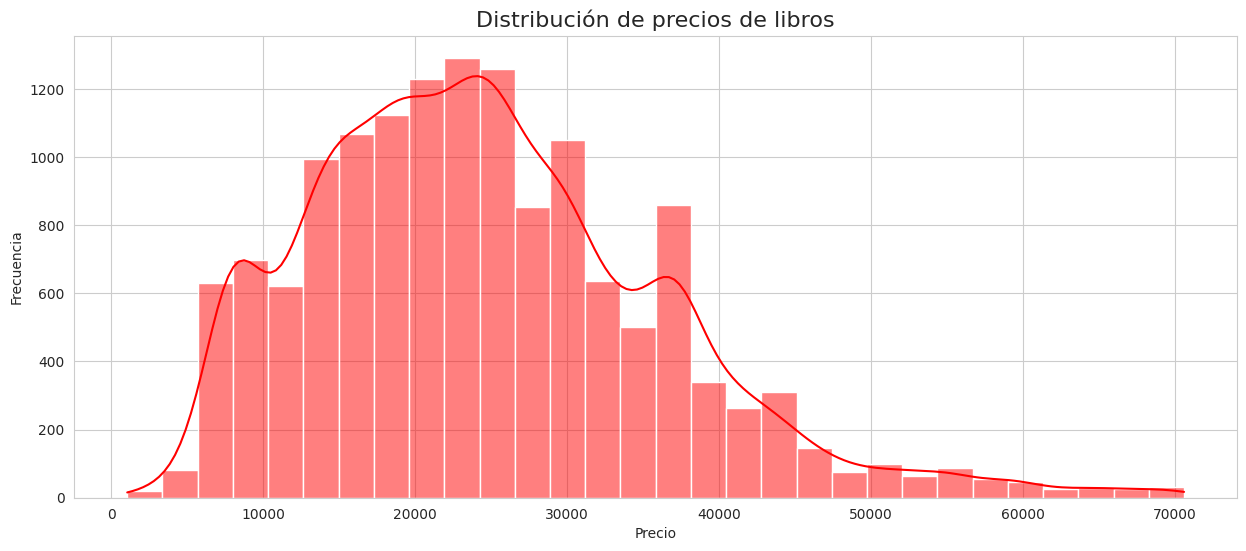

In [ ]:


plt.figure(figsize=(15,6))
sns.histplot(df['precio'], kde=True, bins=30, color='red')

# Añadimos título y etiquetas
plt.title("Distribución de precios de libros", fontsize=16)
plt.xlabel("Precio")
plt.ylabel("Frecuencia")

plt.show()

Revisamos entonces cuales son las categorias mas vendidas

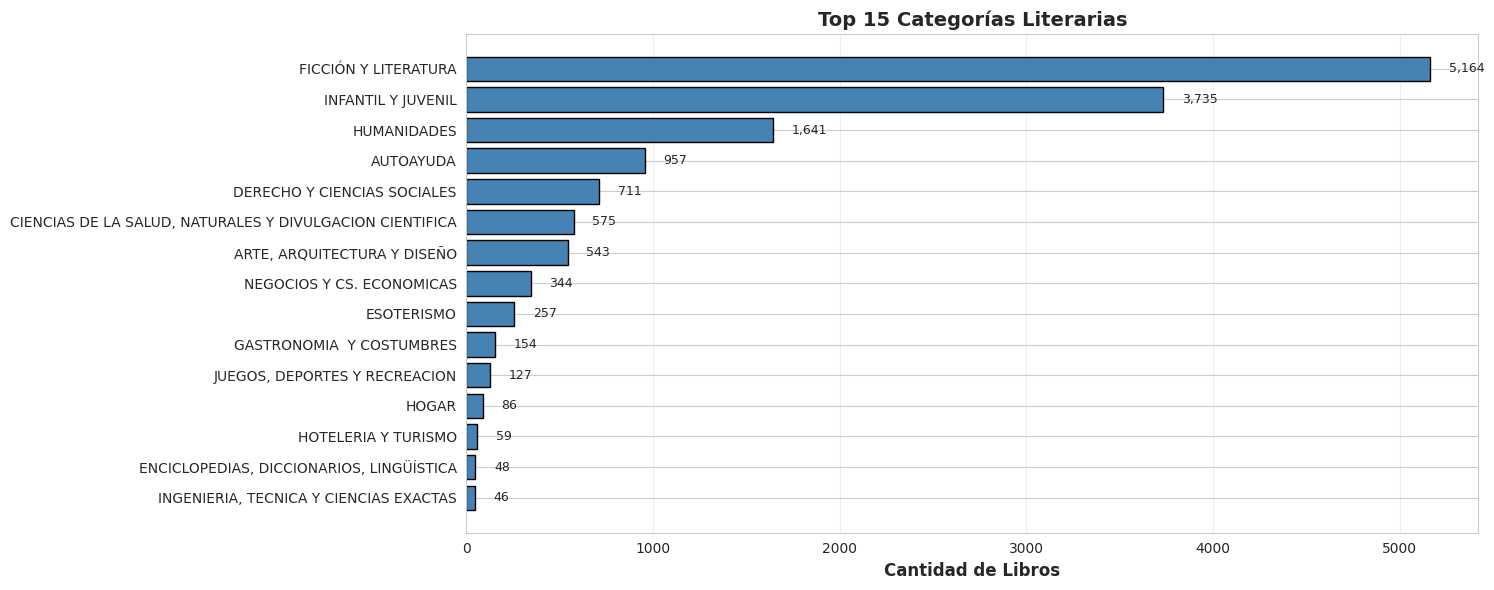

In [ ]:
top_categorias = df['categoria'].value_counts().head(15)

plt.figure(figsize=(15, 6))
plt.barh(range(len(top_categorias)), top_categorias.values, color='steelblue', edgecolor='black')
plt.yticks(range(len(top_categorias)), top_categorias.index, fontsize=10)
plt.xlabel('Cantidad de Libros', fontsize=12, fontweight='bold')
plt.title('Top 15 Categorías Literarias', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)

for i, v in enumerate(top_categorias.values):
    plt.text(v + 100, i, f'{v:,}', va='center', ha='left', fontsize=9)

plt.tight_layout()
plt.show()

Agregamos estadisticas de las paginas de los libros

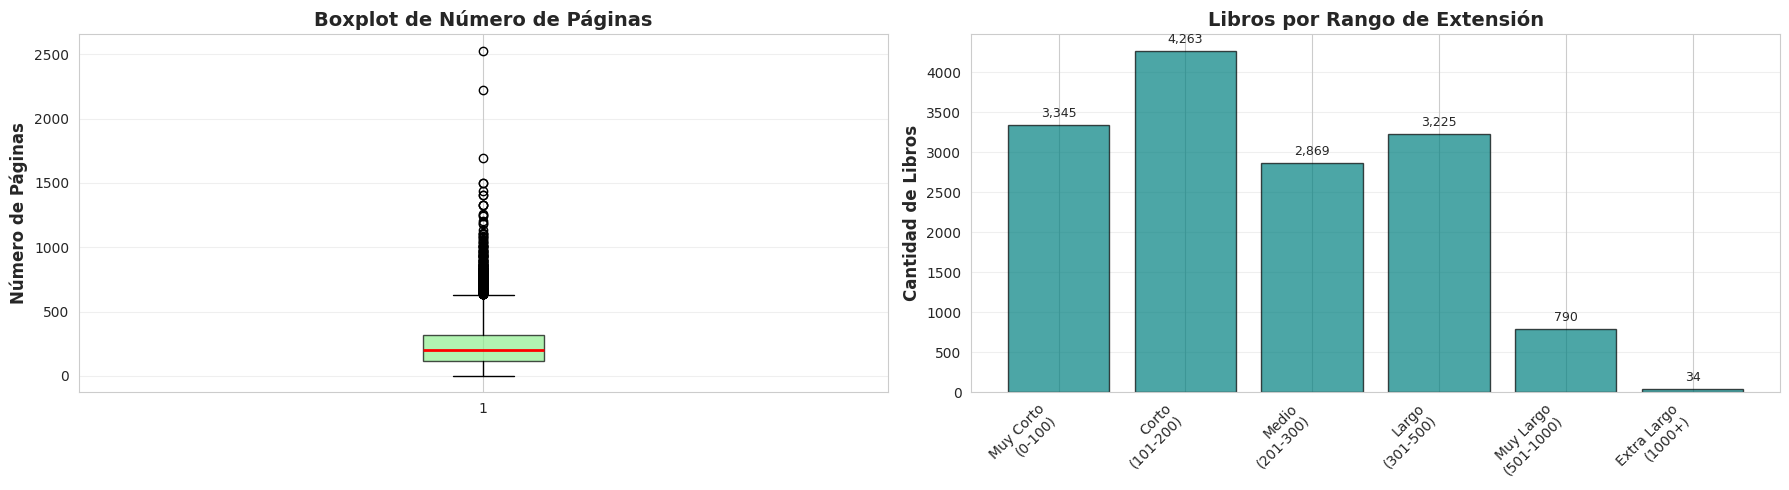


📖 ESTADÍSTICAS DE PÁGINAS:
   Media: 229 páginas
   Mediana: 200 páginas
   Mínimo: 1 páginas
   Máximo: 2528 páginas


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# Boxplot
axes[0].boxplot(df['nro_paginas'], vert=True, patch_artist=True,
                boxprops=dict(facecolor='lightgreen', alpha=0.7),
                medianprops=dict(color='red', linewidth=2))
axes[0].set_ylabel('Número de Páginas', fontsize=12, fontweight='bold')
axes[0].set_title('Boxplot de Número de Páginas', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Categorización por extensión
bins = [0, 100, 200, 300, 500, 1000, 5000]
labels = ['Muy Corto\n(0-100)', 'Corto\n(101-200)', 'Medio\n(201-300)',
          'Largo\n(301-500)', 'Muy Largo\n(501-1000)', 'Extra Largo\n(1000+)']
df_paginas_cat = pd.cut(df['nro_paginas'], bins=bins, labels=labels)
conteo_cat = df_paginas_cat.value_counts().sort_index()

axes[1].bar(range(len(conteo_cat)), conteo_cat.values, color='teal', edgecolor='black', alpha=0.7)
axes[1].set_xticks(range(len(conteo_cat)))
axes[1].set_xticklabels(labels, rotation=45, ha='right')
axes[1].set_ylabel('Cantidad de Libros', fontsize=12, fontweight='bold')
axes[1].set_title('Libros por Rango de Extensión', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Agregar valores
for i, v in enumerate(conteo_cat.values):
    axes[1].text(i, v + 100, f'{v:,}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\n📖 ESTADÍSTICAS DE PÁGINAS:")
print(f"   Media: {df['nro_paginas'].mean():.0f} páginas")
print(f"   Mediana: {df['nro_paginas'].median():.0f} páginas")
print(f"   Mínimo: {df['nro_paginas'].min():.0f} páginas")
print(f"   Máximo: {df['nro_paginas'].max():.0f} páginas")

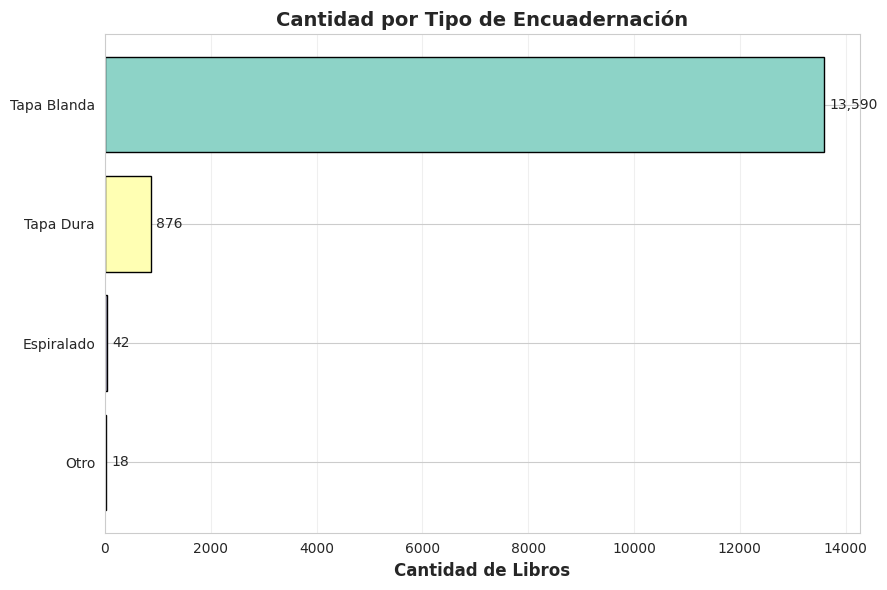


📘 ANÁLISIS DE ENCUADERNACIÓN (Cantidad):
   Tipo más frecuente: Tapa Blanda (13,590 libros)
   Tipos menos frecuentes: Otro (18 libros)


In [ ]:
encuadernacion_counts = df['encuadernacion'].value_counts()
colores = plt.cm.Set3(range(len(encuadernacion_counts)))


plt.figure(figsize=(9, 6))
plt.barh(
    range(len(encuadernacion_counts)),
    encuadernacion_counts.values,
    color=colores,
    edgecolor='black'
)
plt.yticks(range(len(encuadernacion_counts)), encuadernacion_counts.index)
plt.xlabel('Cantidad de Libros', fontsize=12, fontweight='bold')
plt.title('Cantidad por Tipo de Encuadernación', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)

#Etiquetas de valores
for i, v in enumerate(encuadernacion_counts.values):
    plt.text(v + 100, i, f'{v:,}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

# Análisis condicional
print(f"\n📘 ANÁLISIS DE ENCUADERNACIÓN (Cantidad):")
print(f"   Tipo más frecuente: {encuadernacion_counts.index[0]} ({encuadernacion_counts.values[0]:,} libros)")
print(f"   Tipos menos frecuentes: {encuadernacion_counts.index[-1]} ({encuadernacion_counts.values[-1]:,} libros)")


### Analisis Bivariado: Relaciones entre variables

En primera instancia y para entender si lo que hicimos al eliminar los registros nulos y los que estaban en 0 vamos a expresar la relacion entre la cantidad de paginas y el precio:

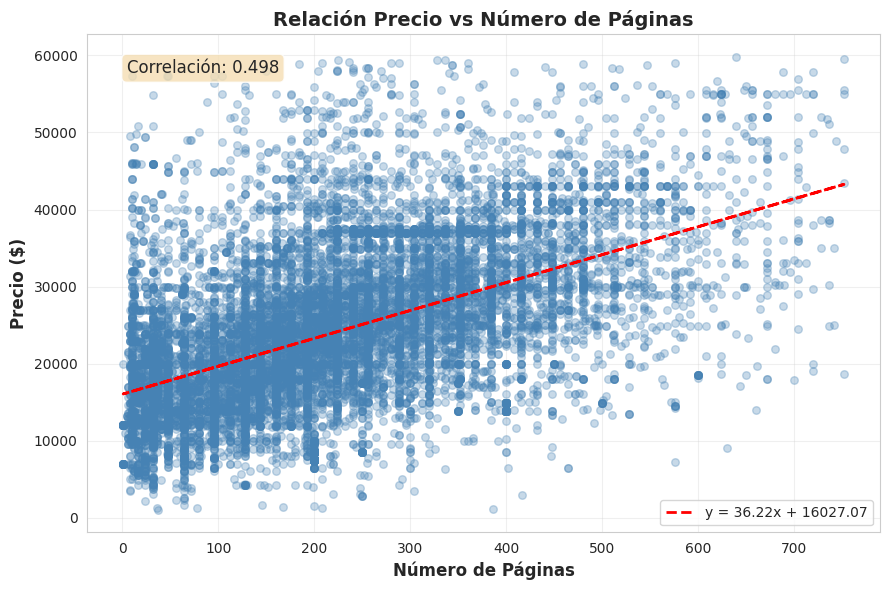


📊 CORRELACIÓN PRECIO vs PÁGINAS:
   Coeficiente de correlación: 0.498
   Interpretación: Correlación MODERADA positiva


In [ ]:
df_clean = df[(df['precio'] < df['precio'].quantile(0.99)) &
              (df['nro_paginas'] < df['nro_paginas'].quantile(0.99))]

plt.figure(figsize=(9, 6))


plt.scatter(df_clean['nro_paginas'], df_clean['precio'], alpha=0.3, s=30, color='steelblue')


z = np.polyfit(df_clean['nro_paginas'], df_clean['precio'], 1)
p = np.poly1d(z)
plt.plot(df_clean['nro_paginas'], p(df_clean['nro_paginas']),
             "r--", linewidth=2, label=f'y = {z[0]:.2f}x + {z[1]:.2f}')

# Calculamos correlación
correlacion = df_clean['nro_paginas'].corr(df_clean['precio'])
plt.text(0.05, 0.95, f'Correlación: {correlacion:.3f}',
             transform=plt.gca().transAxes, fontsize=12,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.xlabel('Número de Páginas', fontsize=12, fontweight='bold')
plt.ylabel('Precio ($)', fontsize=12, fontweight='bold')
plt.title('Relación Precio vs Número de Páginas', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 CORRELACIÓN PRECIO vs PÁGINAS:")
print(f"   Coeficiente de correlación: {correlacion:.3f}")
if correlacion > 0.7:
    print(f"   Interpretación: Correlación FUERTE positiva")
elif correlacion > 0.4:
    print(f"   Interpretación: Correlación MODERADA positiva")
elif correlacion > 0.2:
    print(f"   Interpretación: Correlación DÉBIL positiva")
else:
    print(f"   Interpretación: Correlación MUY DÉBIL o nula")

Vemos que si bien la relacion es positiva no es algo que este TAN proporcionalmente relacionado de manera directa. Entendemos de todas formas que al ser positiva la relacion y estar tan cerca del 0.5 el coeficiente entonces se ha hecho lo correcto al eliminar los registros en 0 y NaN para que el analisis no quede sesgado y el dataset se limpie para el modelo

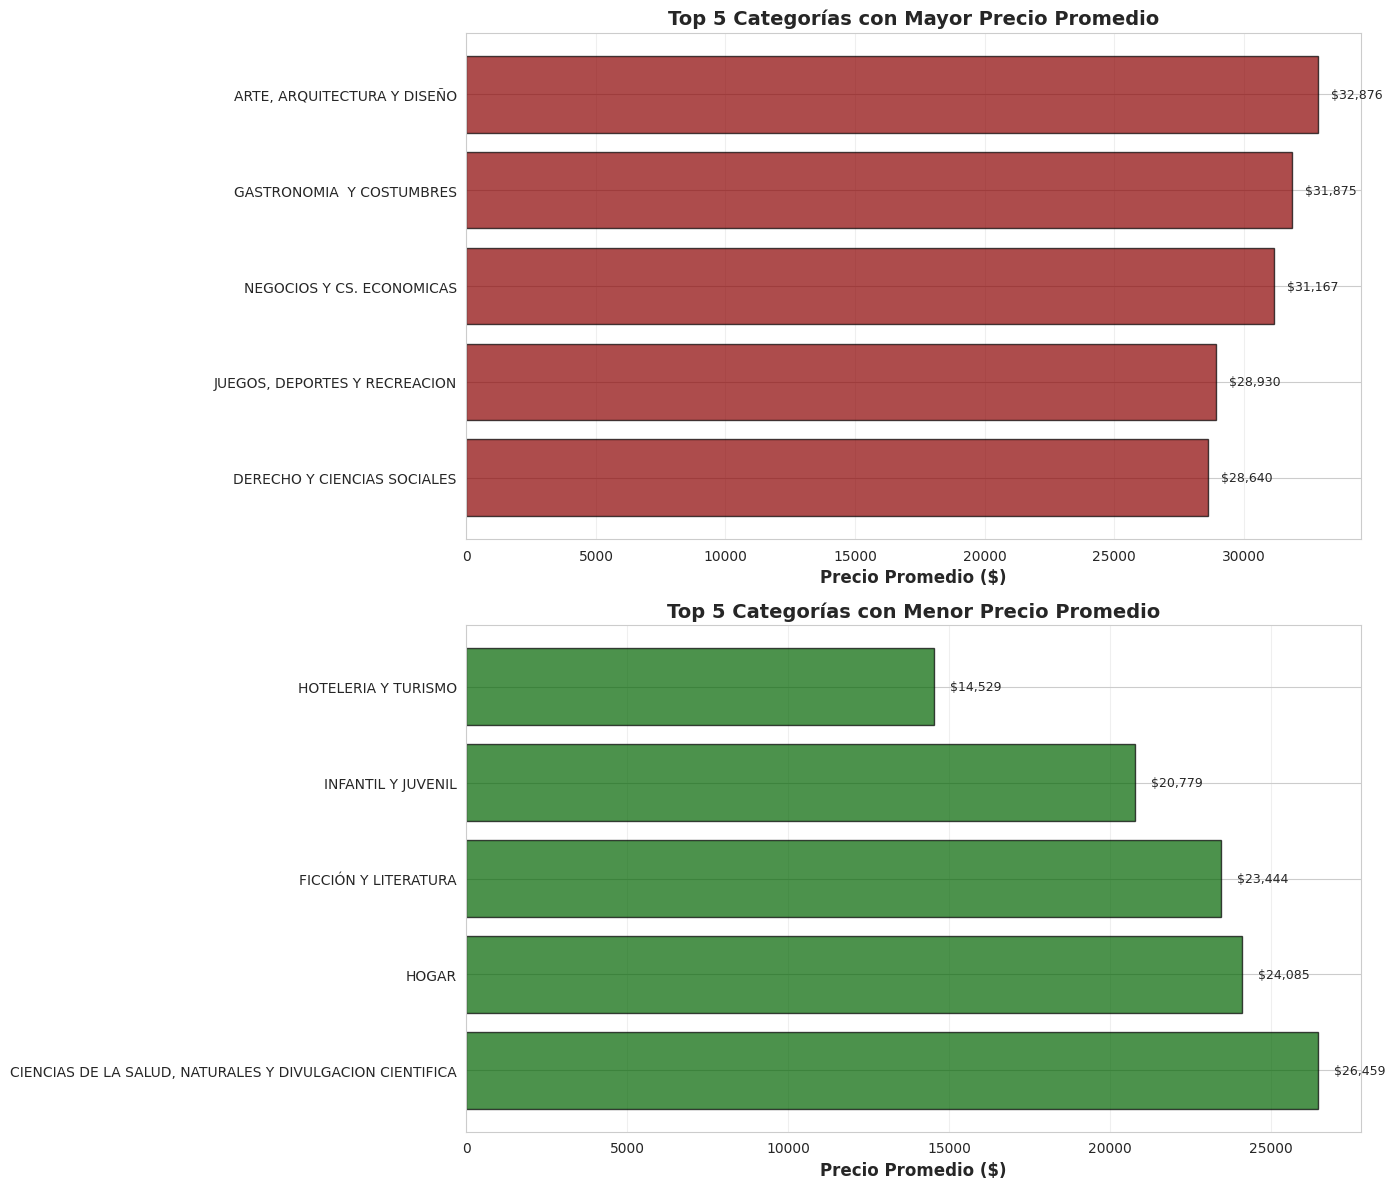


📚 CATEGORÍAS MÁS CARAS:
   ARTE, ARQUITECTURA Y DISEÑO: $32,876.50 (promedio)
   GASTRONOMIA  Y COSTUMBRES: $31,875.19 (promedio)
   NEGOCIOS Y CS. ECONOMICAS: $31,167.16 (promedio)

📚 CATEGORÍAS MÁS ECONÓMICAS:
   HOTELERIA Y TURISMO: $14,528.85 (promedio)
   INFANTIL Y JUVENIL: $20,778.82 (promedio)
   FICCIÓN Y LITERATURA: $23,444.46 (promedio)


In [ ]:
# Calculamos precio promedio por categoría
precio_por_categoria = df.groupby('categoria')['precio'].agg(['mean', 'median', 'count'])
# Filtramos categorías con al menos 50 libros
precio_por_categoria = precio_por_categoria[precio_por_categoria['count'] >= 50]
precio_por_categoria = precio_por_categoria.sort_values('mean', ascending=False).head(5)

fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# Top 5 categorías más caras
axes[0].barh(range(len(precio_por_categoria)), precio_por_categoria['mean'].values,
             color='darkred', edgecolor='black', alpha=0.7)
axes[0].set_yticks(range(len(precio_por_categoria)))
axes[0].set_yticklabels(precio_por_categoria.index, fontsize=10)
axes[0].set_xlabel('Precio Promedio ($)', fontsize=12, fontweight='bold')
axes[0].set_title('Top 5 Categorías con Mayor Precio Promedio', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

for i, v in enumerate(precio_por_categoria['mean'].values):
    axes[0].text(v + 500, i, f'${v:,.0f}', va='center', fontsize=9)

# Top 5 categorías más baratas
precio_por_categoria_baratas = df.groupby('categoria')['precio'].agg(['mean', 'median', 'count'])
precio_por_categoria_baratas = precio_por_categoria_baratas[precio_por_categoria_baratas['count'] >= 50]
precio_por_categoria_baratas = precio_por_categoria_baratas.sort_values('mean', ascending=True).head(5)

axes[1].barh(range(len(precio_por_categoria_baratas)), precio_por_categoria_baratas['mean'].values,
             color='darkgreen', edgecolor='black', alpha=0.7)
axes[1].set_yticks(range(len(precio_por_categoria_baratas)))
axes[1].set_yticklabels(precio_por_categoria_baratas.index, fontsize=10)
axes[1].set_xlabel('Precio Promedio ($)', fontsize=12, fontweight='bold')
axes[1].set_title('Top 5 Categorías con Menor Precio Promedio', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

for i, v in enumerate(precio_por_categoria_baratas['mean'].values):
    axes[1].text(v + 500, i, f'${v:,.0f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\n📚 CATEGORÍAS MÁS CARAS:")
for cat in precio_por_categoria.head(3).index:
    print(f"   {cat}: ${precio_por_categoria.loc[cat, 'mean']:,.2f} (promedio)")

print(f"\n📚 CATEGORÍAS MÁS ECONÓMICAS:")
for cat in precio_por_categoria_baratas.head(3).index:
    print(f"   {cat}: ${precio_por_categoria_baratas.loc[cat, 'mean']:,.2f} (promedio)")

Los libros cuya categoria es 'Ficcion y literatura' y los pertenecientes a la categoria 'Infantil y Juvenil' son de los mas baratos en promedio y a su vez son las categorias mas frecuentes en cuanto a cantidad de libros en el catalogo por lo que podemos entender que esto es lo que hace que la curva se mueva a la derecha en la campana. Y que en el caso de hoteleria y turismo a pesar de ser una de las categorias mas baratas es de la que menos cantidad de libros tiene.

### Analisis Multivariado

Vamos a graficar las relaciones de las variables con la target a traves de la varianza:

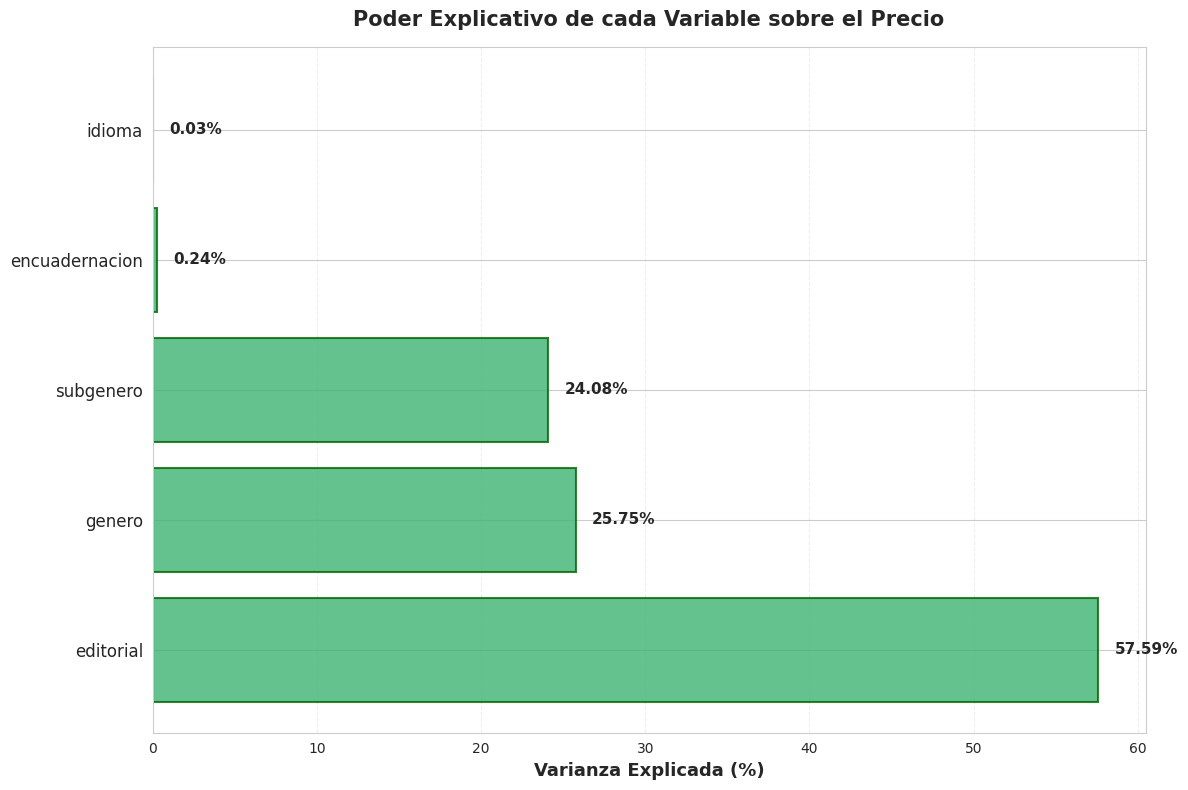

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

# Calculamos la varianza entre grupos vs varianza total para cada variable
variables_cat = ['encuadernacion', 'idioma', 'editorial', 'genero', 'subgenero']
varianza_explicada = {}

for var in variables_cat:
    # Varianza entre grupos
    grupos = df.groupby(var)['precio'].mean()
    varianza_entre = ((grupos - df['precio'].mean())**2 * df.groupby(var)['precio'].count()).sum()
    varianza_total = ((df['precio'] - df['precio'].mean())**2).sum()
    r_cuadrado = varianza_entre / varianza_total
    varianza_explicada[var] = r_cuadrado * 100

# graficamos
var_exp_sorted = dict(sorted(varianza_explicada.items(), key=lambda x: x[1], reverse=True))
bars = ax.barh(range(len(var_exp_sorted)), list(var_exp_sorted.values()),
                alpha=0.8, color='mediumseagreen', edgecolor='darkgreen', linewidth=1.5)
ax.set_yticks(range(len(var_exp_sorted)))
ax.set_yticklabels(list(var_exp_sorted.keys()), fontsize=12)
ax.set_xlabel('Varianza Explicada (%)', fontweight='bold', fontsize=13)
ax.set_title('Poder Explicativo de cada Variable sobre el Precio',
             fontweight='bold', pad=15, fontsize=15)
ax.grid(axis='x', alpha=0.3, linestyle='--')

for i, (bar, val) in enumerate(zip(bars, var_exp_sorted.values())):
    ax.text(val + 1, bar.get_y() + bar.get_height()/2, f'{val:.2f}%',
             va='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()



Poder explicativo de variables categóricas:
   - editorial: 49.77% de la varianza
   - genero: 21.32% de la varianza
   - subgenero: 19.84% de la varianza
   - encuadernacion: 0.57% de la varianza
   - idioma: 0.44% de la varianza

CONCLUSIÓN: La variable 'editorial' es la que mejor explica
la variación de precios con un 49.77% de varianza explicada.

Con la ayuda de la ia transformamos las variables a traves de su precio promedio en numericas para poder medir las relaciones entre ellas y poder entender mas de cerca y por fuera de la variable target:

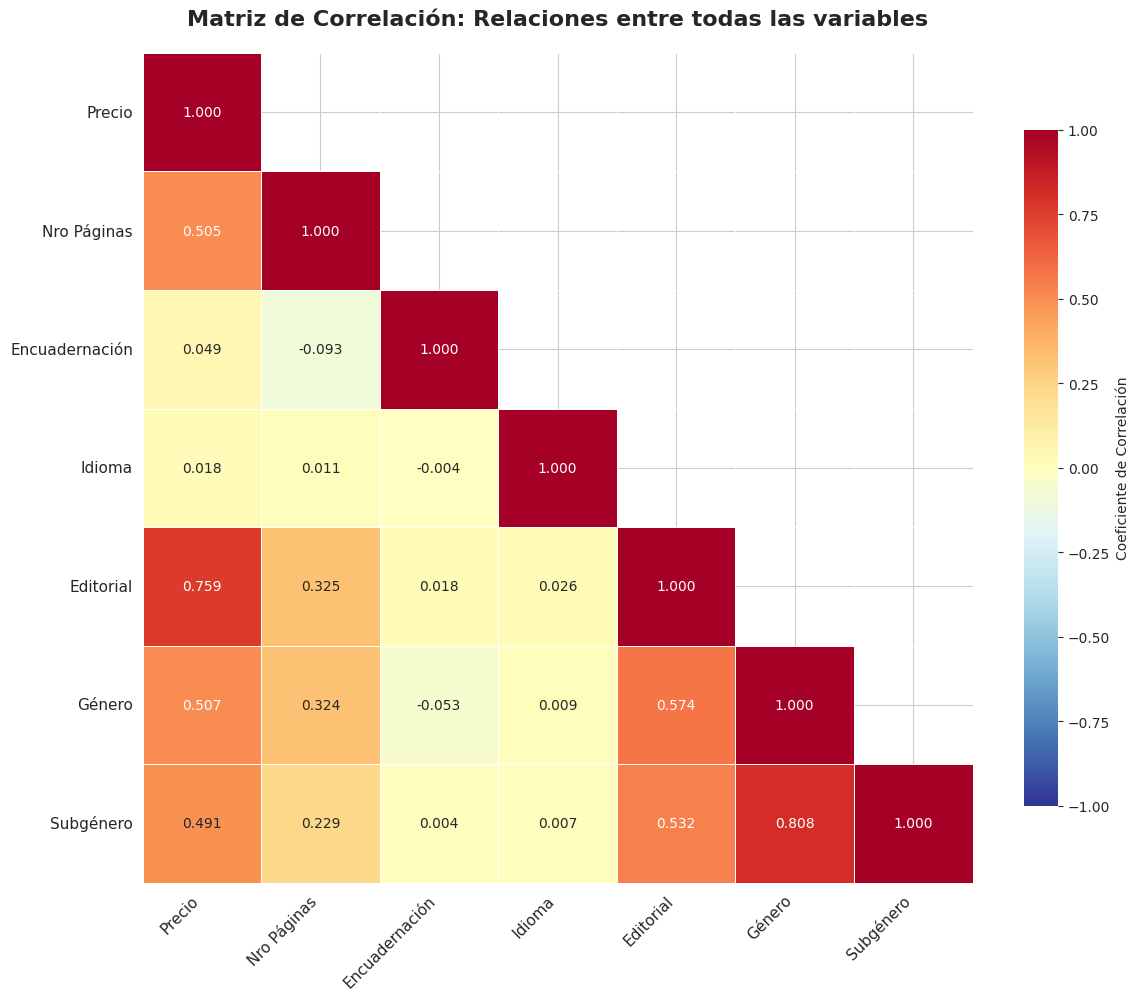

In [ ]:
df_corr = df.copy()

# Convertir variables categóricas a numéricas usando diferentes estrategias

# 1. Encuadernación: por precio promedio
encuad_map = df.groupby('encuadernacion')['precio'].mean().to_dict()
df_corr['encuadernacion_num'] = df_corr['encuadernacion'].map(encuad_map)

# 2. Idioma: por precio promedio
idioma_map = df.groupby('idioma')['precio'].mean().to_dict()
df_corr['idioma_num'] = df_corr['idioma'].map(idioma_map)

# 3. Editorial: por precio promedio
editorial_map = df.groupby('editorial')['precio'].mean().to_dict()
df_corr['editorial_num'] = df_corr['editorial'].map(editorial_map)

# 4. Género: por precio promedio
genero_map = df.groupby('genero')['precio'].mean().to_dict()
df_corr['genero_num'] = df_corr['genero'].map(genero_map)

# 5. Subgénero: por precio promedio
subgenero_map = df.groupby('subgenero')['precio'].mean().to_dict()
df_corr['subgenero_num'] = df_corr['subgenero'].map(subgenero_map)

# Seleccionar solo las columnas numéricas para la correlación
columnas_analisis = {
    'precio': 'Precio',
    'nro_paginas': 'Nro Páginas',
    'encuadernacion_num': 'Encuadernación',
    'idioma_num': 'Idioma',
    'editorial_num': 'Editorial',
    'genero_num': 'Género',
    'subgenero_num': 'Subgénero'
}

# Crear DataFrame con las columnas seleccionadas
df_analisis = df_corr[list(columnas_analisis.keys())].copy()
df_analisis.columns = list(columnas_analisis.values())

# Calcular matriz de correlación
correlation_matrix = df_analisis.corr()

# Crear figura
fig, ax = plt.subplots(figsize=(12, 10))

# Crear heatmap
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)  # Máscara para triángulo superior
sns.heatmap(correlation_matrix,
            annot=True,  # Mostrar valores
            fmt='.3f',  # Formato de 3 decimales
            cmap='RdYlBu_r',  # Colormap (rojo=positivo, azul=negativo)
            center=0,  # Centro en 0
            square=True,  # Celdas cuadradas
            linewidths=0.5,  # Líneas entre celdas
            cbar_kws={'label': 'Coeficiente de Correlación', 'shrink': 0.8},
            vmin=-1, vmax=1,  # Rango de valores
            ax=ax,
            mask=mask)  # Aplicar máscara

# Ajustar título y etiquetas
ax.set_title('Matriz de Correlación: Relaciones entre todas las variables',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('')
ax.set_ylabel('')

# Rotar etiquetas
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(rotation=0, fontsize=11)

plt.tight_layout()
plt.show()


# Obtener correlaciones con precio (excluyendo la diagonal)
corr_precio = correlation_matrix['Precio'].drop('Precio').sort_values(ascending=False)



=== ANÁLISIS DE CORRELACIONES ===

📊 CORRELACIONES CON EL PRECIO:

   Editorial:  0.705       [FUERTE positiva]

   Nro Páginas:  0.515     [FUERTE positiva]

   Género:  0.462          [MODERADA positiva]

   Subgénero:  0.445       [MODERADA positiva]

   Encuadernación:  0.076  [muy débil/nula]

   Idioma:  0.066          [muy débil/nula]


📈 TOP 5 CORRELACIONES MÁS FUERTES (entre otras variables):

   Subgénero ↔ Género: 0.747    (positiva)

   Precio ↔ Editorial: 0.705    (positiva)

   Editorial ↔ Género: 0.528    (positiva)

   Nro Páginas ↔ Precio: 0.515  (positiva)

   Subgénero ↔ Editorial: 0.486 (positiva)


💡 NOTA: Las variables categóricas fueron codificadas por su precio promedio
   para poder calcular correlaciones. Esto permite identificar qué categorías
   tienden a asociarse con precios más altos o más bajos.

# Ingenieria de Variables

Siguiendo el objetivo principal del trabajo que tiene que ver con la entrega de un modelo predictivo que defina el precio a partir de las caracteristicas para poder determianrlo automaticamente, vamos a comenzar a preparar el dataset para poder ejecutar los modelos de la mejor manera.

En primera instancia vamos a crear dos variables mas que puede llegar a afectar el resultado del modelo que tiene que ver con la cantidad de autores que escribieron un libro y con el tiempo que lleva en el mercado:

In [ ]:
#El numeroi de autores implicados en el libro:

df['num_autores'] = df['autor'].str.count('/') + 1

In [ ]:
#La antiguedad que tiene el libro que tambien puede afectar el precio
df['antiguedad'] = 2025 - df['año_publicacion']

Instanciamos y separamos las variables

In [ ]:
df['num_autores'].value_counts()


,count
num_autores,
1,13245
2,1097
3,157
4,17
6,8
5,2


Encodeamos las variables categoricas y escalamos las numericas instanciando el columntransformer

In [ ]:
# Codificamos variables categóricas
variables_numericas = ['nro_paginas', 'antiguedad', 'num_autores']
variables_categoricas = ['autor', 'editorial', 'idioma', 'encuadernacion', 'categoria', 'genero', 'subgenero']

In [ ]:
todas_las_columnas = variables_numericas + variables_categoricas

x = df[todas_las_columnas].copy()
y = df['precio'].copy()

Avanzamos con la division de los datos en train y test usando el  train_test_split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), variables_numericas),
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value',
                               unknown_value=-1),
                variables_categoricas)
    ],
    remainder='drop'
    )

Fiteamos y transformamos los datos de trin y test para ingresarlos al modelo

In [ ]:
#Fiteamos solo train
preprocessor.fit(x_train)

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['nro_paginas', 'antiguedad', 'num_autores']),
                                ('cat',
                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 ['autor', 'editorial', 'idioma',
                                  'encuadernacion', 'categoria', 'genero',
                                  'subgenero'])])

In [ ]:
#transformamos en Train y test
x_train_transformed = preprocessor.transform(x_train)
x_test_transformed = preprocessor.transform(x_test)

In [ ]:
x_train.shape


(10168, 10)

In [ ]:
x_test.shape

(4358, 10)

# Modelos de aprendizaje supervisado

Instanciamos el modelo inicial que es una regresion lineal simple para ver un resultado preliminar de un modelo sin ningun tipo de mejora aplicada ni hiperparametros

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr

LinearRegression()

In [ ]:
lr.fit(x_train_transformed, y_train)


LinearRegression()

In [ ]:
y_pred_test = lr.predict(x_test_transformed)
y_pred_train = lr.predict(x_train_transformed)

In [ ]:
metrics = {
    "Conjunto": ["Train", "Test"],
    "RMSE": [
        np.sqrt(mean_squared_error(y_train, y_pred_train)),
        np.sqrt(mean_squared_error(y_test, y_pred_test))
    ],
    "MAE": [
        mean_absolute_error(y_train, y_pred_train),
        mean_absolute_error(y_test, y_pred_test)
    ],
    "R2": [
        r2_score(y_train, y_pred_train),
        r2_score(y_test, y_pred_test)
    ]
}

# Convertir a DataFrame
metrics_df = pd.DataFrame(metrics)
metrics_df.round(3)

,Conjunto,RMSE,MAE,R2
0,Train,9739.648,7335.345,0.286
1,Test,9493.747,7210.426,0.311


Los resultados son muy malos pero esperados, el R2 es mucho menor que 0.5 tanto en train como test, lo cual nos indica que el modelo esta explicando bastante menos del 50% de la varianza en ambos casos y por ende estamos muy lejos de un modelo que funcione correctamente. Se desvia $7335 pesos del valor real en el caso de train y apenas un poco menos de 100 pesos de diferencia en test.

Avanzamos entonces a revisar tres modelos distintos que puedan acercarnos mas al objetivo

In [ ]:
# Armamos una lista con los 3 modelos elegidos

modelos = {
    "LightGBM": LGBMRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, verbosity=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=42)
}

# Instanciamos las metricas
def get_metrics(y_true, y_pred):
    return {
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred)
    }

# Guardamos los resultados
results = []

# Entrenamos y evaluamos el resultado
for name, model in modelos.items():
    model.fit(x_train_transformed, y_train)

    y_train_pred = model.predict(x_train_transformed)
    y_test_pred = model.predict(x_test_transformed)

    train_metrics = get_metrics(y_train, y_train_pred)
    train_metrics.update({"Modelo": name, "Conjunto": "Train"})
    results.append(train_metrics)

    test_metrics = get_metrics(y_test, y_test_pred)
    test_metrics.update({"Modelo": name, "Conjunto": "Test"})
    results.append(test_metrics)

# Convertir resultados a DataFrame de pandas
metrics_df = pd.DataFrame(results)[["Modelo", "Conjunto", "RMSE", "MAE", "R2"]]

# Mostrar resultados
metrics_df

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1088
[LightGBM] [Info] Number of data points in the train set: 10168, number of used features: 10
[LightGBM] [Info] Start training from score 24578.572777


,Modelo,Conjunto,RMSE,MAE,R2
0,LightGBM,Train,6320.877099,4446.411631,0.699476
1,LightGBM,Test,7209.513393,5033.350843,0.602810
2,XGBoost,Train,4389.075301,3071.071289,0.855099
3,XGBoost,Test,7216.343395,4929.141602,0.602058
4,ExtraTreesRegressor,Train,582.908308,52.606894,0.997444
5,ExtraTreesRegressor,Test,7388.394990,4932.758327,0.582856


Detalles del resultado:

▶ **ExtraTreesRegressor**	claramente esta overfitteando en train y tiene mucha diferencia entre train y test por lo que no esta generalizando bien y a su vez el MAE es mas de 100 veces mayor en test por lo que queda descartado.

▶ **XGBoost**	 Tiene errores bastante bajos y parejos entre train y test y el R2 es bastante bueno tambien pero hay mucha brecha entre train y test

▶ **LightGBM** : Mejor balance train/test con Solo 9.6 puntos de diferencia y Más estable y confiable para producción.

El ganador para tunear hiperparametros es el **LightGBM** 🥇


###Tuning de hiperparametros - LightGBM

Para el tuning de parametros se elige HalvingGridSearchCV porque al tener muchas variables y datos entendemos que gridsearch va a demorar mucho innecesariamente y randomized no va a aprovechar la informacion que probablemente sea crucial para la mejora del modelo. Teniendo en cuenta que HGSCV optimiza recursos y los va aumentando solo a necesidad lo encontramos ideal para avanzar.

In [ ]:
param_grid = {
    "learning_rate": [0.05, 0.1],
    "max_depth": [5, 7],
    "num_leaves": [31, 40],
    "min_child_samples": [20, 40],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "reg_alpha": [0, 0.1, 0.5],
    "reg_lambda": [0, 0.1, 0.5],
}

In [ ]:
# Modelo base sobre el cual se hará el tuning
lgbm_base = LGBMRegressor(
    random_state=42,
    n_jobs=-1,
    verbose=-1 # Usar verbose=-1 en lugar de silent=True
)

# Configuramos HalvingGridSearchCV
halving_search = HalvingGridSearchCV(
    estimator=lgbm_base,
    param_grid=param_grid,
    scoring="neg_mean_absolute_error",
    cv=3,
    factor=4,
    resource="n_estimators",
    min_resources=50,
    max_resources=200,
    random_state=42,
    verbose=1,
    n_jobs=-1
)

In [ ]:
halving_search.fit(x_train_transformed, y_train)

n_iterations: 2
n_required_iterations: 5
n_possible_iterations: 2
min_resources_: 50
max_resources_: 200
aggressive_elimination: False
factor: 4
----------
iter: 0
n_candidates: 576
n_resources: 50
Fitting 3 folds for each of 576 candidates, totalling 1728 fits
----------
iter: 1
n_candidates: 144
n_resources: 200
Fitting 3 folds for each of 144 candidates, totalling 432 fits


HalvingGridSearchCV(cv=3,
                    estimator=LGBMRegressor(n_jobs=-1, random_state=42,
                                            verbose=-1),
                    factor=4, max_resources=200, min_resources=50, n_jobs=-1,
                    param_grid={'colsample_bytree': [0.8, 1.0],
                                'learning_rate': [0.05, 0.1],
                                'max_depth': [5, 7],
                                'min_child_samples': [20, 40],
                                'num_leaves': [31, 40],
                                'reg_alpha': [0, 0.1, 0.5],
                                'reg_lambda': [0, 0.1, 0.5],
                                'subsample': [0.8, 1.0]},
                    random_state=42, resource='n_estimators',
                    scoring='neg_mean_absolute_error', verbose=1)

In [ ]:
# Extraemos el mejor modelo encontrado
best_model = halving_search.best_estimator_

# Mostramos los mejores hiperparámetros
print("Mejores hiperparámetros encontrados:")
for param, value in halving_search.best_params_.items():
    print(f"{param}: {value}")

# Score de validación cruzada (convertimos el negativo)
best_cv_score = -halving_search.best_score_
print(f"\nMSE en validación cruzada: {best_cv_score:.2f}")
print(f"RMSE en validación cruzada: {best_cv_score ** 0.5:.2f}")

Mejores hiperparámetros encontrados:
colsample_bytree: 0.8
learning_rate: 0.1
max_depth: 7
min_child_samples: 20
num_leaves: 40
reg_alpha: 0.5
reg_lambda: 0
subsample: 0.8
n_estimators: 200

MSE en validación cruzada: 5042.76
RMSE en validación cruzada: 71.01


In [ ]:
# Predicciones
y_pred_train = best_model.predict(x_train_transformed)
y_pred_test = best_model.predict(x_test_transformed)


In [ ]:
# Función auxiliar para calcular métricas
def get_metrics(y_true, y_pred):
    """Calcula métricas de regresión"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2
    }

# Calcular métricas para train y test
train_metrics = get_metrics(y_train, y_pred_train)
test_metrics = get_metrics(y_test, y_pred_test)

# Crear DataFrame de resultados
results = [
    {"Modelo": "LightGBM Tuned", "Conjunto": "Train", **train_metrics},
    {"Modelo": "LightGBM Tuned", "Conjunto": "Test", **test_metrics}
]

df_results = pd.DataFrame(results)

print("\n📊 Métricas del modelo optimizado:")
print(df_results.to_string(index=False))


📊 Métricas del modelo optimizado:
        Modelo Conjunto          MSE        RMSE         MAE       R²
LightGBM Tuned    Train 3.173181e+07 5633.099788 3922.011829 0.761318
LightGBM Tuned     Test 4.862275e+07 6973.001415 4840.554677 0.628443


Guardamos los parametros en un objeto

In [ ]:
best_params = best_model.get_params()
best_params

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.8,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': 7,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 200,
 'n_jobs': -1,
 'num_leaves': 40,
 'objective': None,
 'random_state': 42,
 'reg_alpha': 0.5,
 'reg_lambda': 0,
 'subsample': 0.8,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'verbose': -1}

Comparamos resultados con el Modelo original de regresion lineal

In [ ]:
# Métricas de la regresión lineal (TEST)
rmse_lr = 9493.747
mae_lr = 7210.426
r2_lr = 0.311

# Métricas del LightGBM tuneado (TEST)
rmse_lgbm = 6973.001
mae_lgbm = 4840.555
r2_lgbm = 0.628

# DataFrame comparativo
metrics_comparison = pd.DataFrame({
    "Modelo": ["Regresión Lineal", "LightGBM Tuneado"],
    "RMSE": [rmse_lr, rmse_lgbm],
    "MAE": [mae_lr, mae_lgbm],
    "R2": [r2_lr, r2_lgbm]
})

metrics_comparison

,Modelo,RMSE,MAE,R2
0,Regresión Lineal,9493.747,7210.426,0.311
1,LightGBM Tuneado,6973.001,4840.555,0.628


A simple vista podemos observar que lo mejora en todas las metricas y que la mejora de hiperparametros a contribuido a la optimizacion del modelo

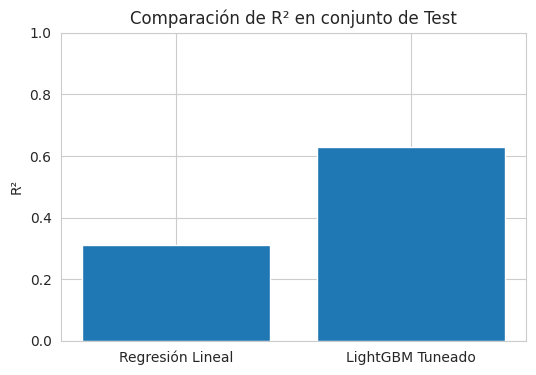

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.bar(metrics_comparison["Modelo"], metrics_comparison["R2"])
plt.title("Comparación de R² en conjunto de Test")
plt.ylabel("R²")
plt.ylim(0, 1)
plt.show()


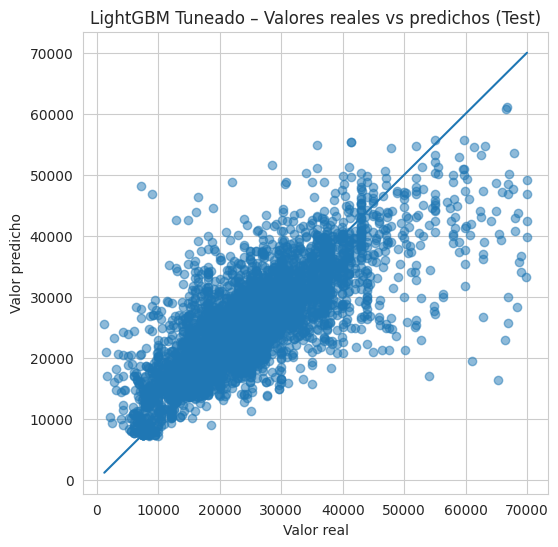

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_test, alpha=0.5)

# Línea de predicción perfecta
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()]
)

plt.xlabel("Valor real")
plt.ylabel("Valor predicho")
plt.title("LightGBM Tuneado – Valores reales vs predichos (Test)")
plt.show()


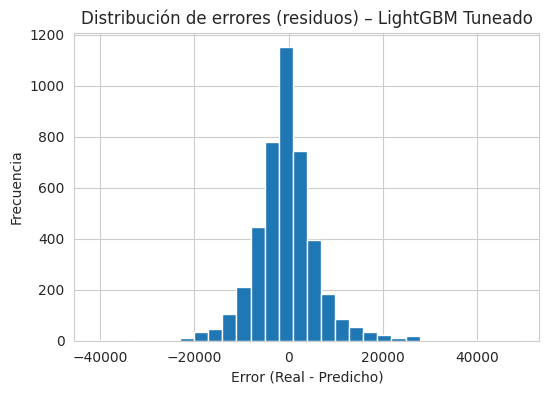

In [ ]:
# Cálculo de residuos
residuals = y_test - y_pred_test

plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=30)
plt.title("Distribución de errores (residuos) – LightGBM Tuneado")
plt.xlabel("Error (Real - Predicho)")
plt.ylabel("Frecuencia")
plt.show()


La comparación entre la regresión lineal y el modelo LightGBM optimizado muestra una mejora significativa en todas las métricas de evaluación. El incremento del R² en el conjunto de test indica una mayor capacidad explicativa del modelo final.

El análisis de valores reales versus predichos evidencia una buena alineación general, mientras que la distribución de los residuos sugiere un comportamiento estable y sin sesgos relevantes, lo que confirma una correcta generalización del modelo.

#Validacion cruzada



Definimos primero el modelo final

In [ ]:
best_model = LGBMRegressor(**best_params)
best_model

LGBMRegressor(colsample_bytree=0.8, max_depth=7, n_estimators=200, n_jobs=-1,
              num_leaves=40, random_state=42, reg_alpha=0.5, reg_lambda=0,
              subsample=0.8, verbose=-1)

In [ ]:
# Transformamos el conjunto completo X usando el preprocessor ya ajustado
X_transformed_full = preprocessor.transform(x)
best_model.fit(X_transformed_full, y)

LGBMRegressor(colsample_bytree=0.8, max_depth=7, n_estimators=200, n_jobs=-1,
              num_leaves=40, random_state=42, reg_alpha=0.5, reg_lambda=0,
              subsample=0.8, verbose=-1)

Hacemos validacion cruzada

In [ ]:
scoring = {
    'MSE': 'neg_mean_squared_error',
    'MAE': 'neg_mean_absolute_error',
    'R2': 'r2'
}

# Transformamos el conjunto completo X usando el preprocessor ya ajustado
X_transformed_full = preprocessor.transform(x)

# Realizamos la validación cruzada con el mejor modelo encontrado
cv_results = cross_validate(
    estimator=best_model,
    X=X_transformed_full, # Usamos la X transformada
    y=y,
    cv=5, # Número de pliegues (folds)
    scoring=scoring,
    return_train_score=False # Generalmente solo nos interesan las puntuaciones de test
)

# Convertimos los resultados a positivos y calculamos el promedio
mse_scores = -cv_results['test_MSE']
mae_scores = -cv_results['test_MAE']
rmse_scores = np.sqrt(mse_scores) # Calculamos RMSE a partir de MSE
r2_scores = cv_results['test_R2']

print(" Métricas de Validación Cruzada (Promedio +/- Desv Estándar)\n")
print(f"Media MSE: {np.mean(mse_scores):.2f} (+/- {np.std(mse_scores):.2f})")
print(f"Media RMSE: {np.mean(rmse_scores):.2f} (+/- {np.std(rmse_scores):.2f})")
print(f"Media MAE: {np.mean(mae_scores):.2f} (+/- {np.std(mae_scores):.2f})")
print(f"Media R2: {np.mean(r2_scores):.2f} (+/- {np.std(r2_scores):.2f})")

# ver los resultados por fold
cv_df = pd.DataFrame(cv_results)
print("\nResultados detallados por fold:\n")
print(cv_df)


 Métricas de Validación Cruzada (Promedio +/- Desv Estándar)

Media MSE: 49462788.43 (+/- 1994294.21)
Media RMSE: 7031.57 (+/- 140.87)
Media MAE: 4817.13 (+/- 73.17)
Media R2: 0.63 (+/- 0.01)

Resultados detallados por fold:

   fit_time  score_time      test_MSE     test_MAE   test_R2
0  0.248273    0.029131 -4.956157e+07 -4827.361534  0.629272
1  0.277744    0.032963 -4.744990e+07 -4739.281328  0.643315
2  0.445097    0.065021 -5.293995e+07 -4933.520769  0.621263
3  1.559200    0.058659 -4.756046e+07 -4738.571422  0.622610
4  0.629712    0.028637 -4.980207e+07 -4846.905771  0.613144


##Feature importance

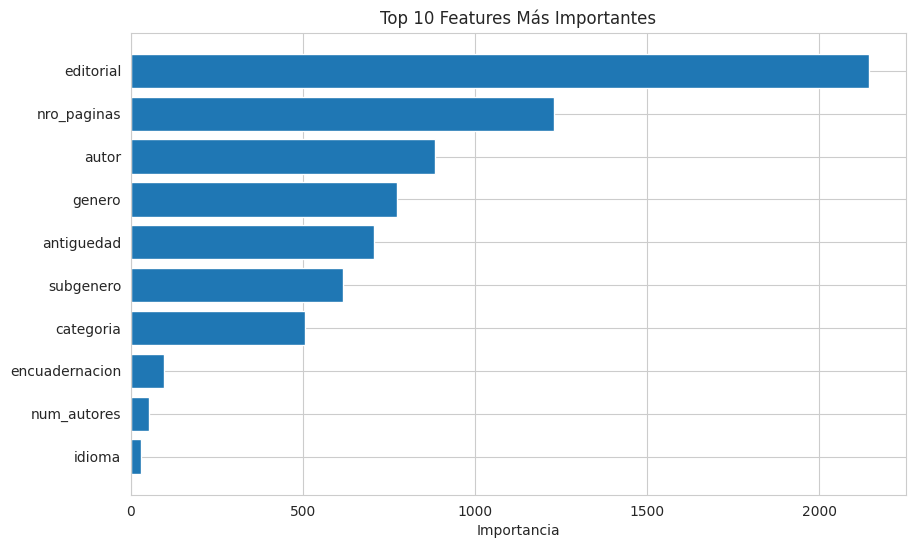

In [39]:
# Obtenemos importancia de features
importance = best_model.feature_importances_
feature_names = variables_numericas + variables_categoricas

# Creamos DataFrame para visualizar
import pandas as pd
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
}).sort_values('importance', ascending=False)

# Visualizacion
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['feature'][:10], feature_importance_df['importance'][:10])
plt.xlabel('Importancia')
plt.title('Top 10 Features Más Importantes')
plt.gca().invert_yaxis()
plt.show()

**Análisis de la Importancia de las Características**

El gráfico y la tabla muestran las 10 características más influyentes en la predicción del precio de un libro, según nuestro modelo LightGBM:

- **Editorial**: Confirma nuestra observación previa de que la editorial es, con diferencia, el factor más determinante en el precio. Esto sugiere que las políticas de precios, el prestigio y el tipo de catálogo de cada editorial tienen un impacto muy significativo.
- **Número de Páginas**: Como era de esperar, la extensión del libro sigue siendo una variable clave, con una correlación positiva con el precio.
- **Autor**: La popularidad o reputación del autor es un factor importante, lo que se traduce en su influencia sobre el precio.
- **Género y Subgénero**: Estas categorías literarias también juegan un rol sustancial, indicando que el tipo de contenido y su nicho de mercado afectan directamente el valor.
- **Antigüedad**: La edad del libro (desde su publicación) también influye, probablemente reflejando depreciación o el estado del mercado. Tuvo sentido haber creado esta variable porque finalmente fue util en el proceso de aprendizaje del modelo.

Características como la encuadernación, el número de autores y el idioma muestran una importancia mucho menor, lo que implica que su impacto en el precio es marginal en comparación con las variables principales.

Esta información es crucial para entender qué atributos de un libro son los más relevantes a la hora de determinar su precio, proporcionando insights valiosos para la estrategia de pricing.

# Conclusión

En **conclusión**, el modelo final (tras la optimización con HalvingGridSearchCV) demuestra ser una solución viable para el problema de regresión. Si bien el valor de \(R^{2}=0.63\) no es perfecto, representa una mejora importante sobre los modelos base iniciales. El modelo ofrece predicciones razonablemente precisas con un error promedio absoluto de 4,817 unidades. Estos resultados, validados mediante cross-validation, proporcionan una estimación confiable y poco sesgada de cómo se comportará el modelo en un entorno de producción con datos no vistos.

 ¿Puede funcionar en producción?
**SÍ, PERO** con limitaciones claras:

- Sistema de recomendación de precios (no definitivo)

- Detección de anomalías: por ej. "Este libro está muy por encima/debajo del precio esperado"

- Primera aproximación al precio para revisión humana posterior

**Fortalezas del Modelo:**

- Capacidad Explicativa Aceptable: El modelo explica el 62.8% de la variabilidad en los precios de libros, lo cual es razonable considerando la complejidad y subjetividad inherente a la fijación de precios editoriales.

- Balance Sesgo-Varianza: Con un gap train-test de 0.133, el modelo demuestra una buena capacidad de generalización sin overfitting severo.

- Mejora Sustancial: Duplica el R² de la regresión lineal baseline y reduce el error en un tercio, demostrando que los modelos de ensamble capturan mejor las relaciones no lineales en los datos.

- Distribución de Errores Centrada: Los residuos se distribuyen aproximadamente normal alrededor de cero, indicando que el modelo no tiene sesgo sistemático.

**Limitaciones Identificadas:**

- Error Absoluto Medio Significativo: Con un MAE de $4,840, el modelo tiene un error relativo sobre el precio promedio de los libros. Este margen de error es considerable y limita su uso para pricing automático sin supervisión.

- Variabilidad Alta en Ciertos Casos: El RMSE de $6,973 sugiere que existen predicciones con errores sustancialmente mayores al promedio, especialmente en libros con características atípicas.

- Dependencia de Categorías Vistas: El modelo tiene dificultades con autores o editoriales no presentes en el conjunto de entrenamiento.

- Complejidad Intrínseca del Problema: Los precios de libros dependen de factores no capturados en los datos (prestigio del autor, demanda del mercado, costos de producción, estrategia comercial), lo cual establece un límite teórico al rendimiento alcanzable.


#Pipeline

In [ ]:
# Definición de Variables
variables_numericas = ['nro_paginas', 'antiguedad', 'num_autores']
variables_categoricas = ['autor', 'editorial', 'idioma', 'encuadernacion', 'categoria', 'genero', 'subgenero']

#Separacion en X e Y
x = df[variables_numericas + variables_categoricas].copy()
y = df['precio'].copy()

# División de datos
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)


# Creación del Preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), variables_numericas),
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), variables_categoricas)
    ],
    remainder='drop'
)

# Definición del Modelo LightGBMRegressor
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', best_model)
])

In [ ]:
# Entrenar
final_pipeline.fit(x, y)

# Guardar el pipeline completo
joblib.dump(final_pipeline, 'modelo_pricing_editorial.pkl')

['modelo_pricing_editorial.pkl']